In [17]:
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline     
import torch
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings
from tigramite.lpcmci import LPCMCI
import seaborn as sns
# from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.rcot import RCOT
# from tigramite.independence_tests.cmisymb import CMIsymb

ModuleNotFoundError: No module named 'tigramite.independence_tests.rcot'

In [8]:
import numpy as np
import pandas as pd

# Constants
num_samples = 306
time_steps_per_sample = 144
num_vars = 8
nan_rows_between_samples = 2

# Define the link assumptions
link_assumptions = {j: {(i, -tau): '' for i in range(num_vars) for tau in range(2) if (i, -tau) != (j, 0)}
                    for j in range(num_vars)}

link_assumptions[0][(1, 0)] = '<?-'  # Example: Var1 (Nd) depends on Var2 (P)
link_assumptions[1][(0, 0)] = '-?>'
link_assumptions[7][(1, 0)] = '<?-'  # Example: Var8 (CF) depends on Var2 (P)
link_assumptions[1][(7, 0)] = '-?>'
link_assumptions[0][(0, -1)] = '-?>' # Var1 (Nd) depends on its own lag
link_assumptions[0][(1, -1)] = '-?>' # Var1 (Nd) depends on Var2 (P) lag
link_assumptions[7][(1, -1)] = '-?>' # Var8 (CF) depends on Var2 (P) lag

link_assumptions[7][(0, -1)] = 'o?>' # Var8 (CF) depends on Var1 (Nd) lag
link_assumptions[1][(0, -1)] = 'o?>' # Var2 (P) depends on Var1 (Nd) lag
link_assumptions[1][(7, -1)] = 'o?>' # Var2 (P) depends on Var8 (CF) lag
link_assumptions[7][(7, -1)] = 'o?>' # Var8 (CF) depends on its own lag

for j in range(2, 7):
    link_assumptions[j][(0, 0)] = '<?-'  # Var3 to Var7 (meteorological) depend on Var1 (Nd)
    link_assumptions[0][(j, 0)] = '-?>'
    link_assumptions[j][(7, 0)] = '<?-'  # Var3 to Var7 (meteorological) depend on Var8 (CF)
    link_assumptions[7][(j, 0)] = '-?>'

# Function to apply dependencies based on link assumptions
def apply_dependencies(sample, link_assumptions):
    for j in range(num_vars):
        for (i, lag), dependency in link_assumptions[j].items():
            if dependency == '<?-':  # i influences j at lag 0
                sample[:, j] += 0.5 * np.tanh(sample[:, i])
            elif dependency == '-?>':  # j influences i at lag 0
                sample[:, i] += 0.3 * np.tanh(sample[:, j])
            elif dependency == 'o?>':  # lagged influence
                for t in range(-lag, time_steps_per_sample):
                    sample[t, j] += 0.2 * np.tanh(sample[t + lag, i])
    return sample

# Generate stationary time series data
def generate_stationary_sample():
    np.random.seed(42)  # For reproducibility
    
    # Use random walks (differences of random walks are stationary)
    sample = np.cumsum(np.random.randn(time_steps_per_sample, num_vars), axis=0)
    
    sample = apply_dependencies(sample, link_assumptions)
    
    # Differencing to ensure stationarity
    sample = np.diff(sample, axis=0)
    
    return sample

# Create all samples with NaN rows in between
all_samples = []
for _ in range(num_samples):
    sample = generate_stationary_sample()
    all_samples.append(sample)
    # Add NaN rows between samples
    all_samples.append(np.full((nan_rows_between_samples, num_vars), np.nan))

# Combine into a single DataFrame
data = np.vstack(all_samples)
df = pd.DataFrame(data, columns=[f"Var{i+1}" for i in range(num_vars)])

print(df)


           Var1      Var2      Var3      Var4      Var5      Var6      Var7  \
0     -0.211511  0.686494 -0.789091 -0.791403 -0.083711 -2.238953 -2.050591   
1     -1.123877 -0.440372 -2.628680 -3.132960 -0.255008 -1.946433 -1.653128   
2     -0.545733  0.008600 -0.226612  1.300080  0.323743  0.632688  0.322675   
3     -0.761197 -0.961258  0.592902 -1.450487 -0.020780 -2.189313 -1.557829   
4      0.953858  0.390902  0.403732  0.218276 -0.959142 -0.200464  0.058741   
...         ...       ...       ...       ...       ...       ...       ...   
44365 -0.064140  0.297303  0.534681  0.635245  1.827035  0.666858 -0.030833   
44366  1.189485 -1.154137  0.607193  0.710966 -0.287771  1.385500 -0.140263   
44367 -0.173072 -0.197275 -1.984318 -2.328094  0.706462 -1.735004 -1.879435   
44368       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
44369       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

           Var8  
0      0.118094  
1     -1.467715

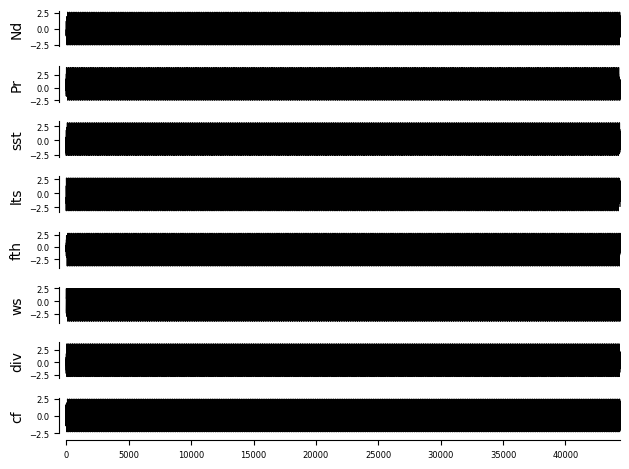

In [9]:
dat = df.values

# empty list to store the modified columns to separate trajectories
modified_columns = []

for col in range(dat.shape[1]):
    column_data = dat[:, col]
    
    # append the modified column to the list
    modified_columns.append(column_data)

modified_data = np.column_stack(modified_columns)

dat = modified_data # handle missingness
n_a_n = np.isnan(dat).any(axis=1)
dat[n_a_n] = 999
#dat = dat[0:150,:]

# initialize dataframe object, specify variable names
var_names = ['Nd','Pr','sst','lts','fth','ws','div','cf']
dataframe = pp.DataFrame(dat, var_names=var_names, missing_flag = 999)
tp.plot_timeseries(dataframe); plt.show()


Starting preliminary phase  1

Starting test phase

p = 0
(0,-2) independent (0, 0) given () union set()
(0,-1) independent (0, 0) given () union set()
(1,-2) independent (1, 0) given () union set()
(1,-1) independent (1, 0) given () union set()
(2,-2) independent (2, 0) given () union set()
(2,-1) independent (2, 0) given () union set()
(3,-2) independent (3, 0) given () union set()
(3,-1) independent (3, 0) given () union set()
(4,-2) independent (4, 0) given () union set()
(4,-1) independent (4, 0) given () union set()
(5,-2) independent (5, 0) given () union set()
(5,-1) independent (5, 0) given () union set()
(6,-2) independent (6, 0) given () union set()
(6,-1) independent (6, 0) given () union set()
(7,-2) independent (7, 0) given () union set()
(7,-1) independent (7, 0) given () union set()
Writing:   (0,-2) oL> (0, 0) ==> (0,-2)     (0, 0) 
Writing:   (0,-1) oL> (0, 0) ==> (0,-1)     (0, 0) 
Writing:   (1,-2) oL> (1, 0) ==> (1,-2)     (1, 0) 
Writing:   (1,-1) oL> (1, 0) ==> 

'\ngraph : array of shape (N, N, tau_max+1)\n            Resulting DPAG, representing the learned causal relationships.\n        val_matrix : array of shape (N, N, tau_max+1)\n            Estimated matrix of test statistic values regarding adjacencies.\n        p_matrix : array of shape [N, N, tau_max+1]\n            Estimated matrix of p-values regarding adjacencies.\n'

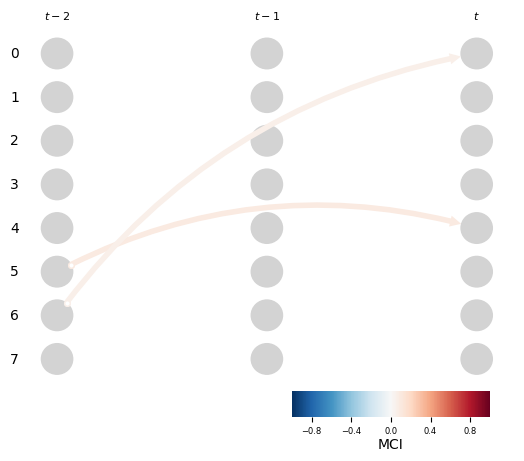

In [10]:
cmi_knn = CMIknn(significance='fixed_thres', model_selection_folds=3)
lpcmci_loc = LPCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=1)
results = lpcmci_loc.run_lpcmci(tau_max=2, pc_alpha=.05)#, link_assumptions = link_assumptions)
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'], save_name = "parcorr_simulated_nolinkass.png")

'''
graph : array of shape (N, N, tau_max+1)
            Resulting DPAG, representing the learned causal relationships.
        val_matrix : array of shape (N, N, tau_max+1)
            Estimated matrix of test statistic values regarding adjacencies.
        p_matrix : array of shape [N, N, tau_max+1]
            Estimated matrix of p-values regarding adjacencies.
'''

In [11]:
print(results['val_matrix'])

[[[ 0.00000000e+00  1.11789491e-02  2.10604930e-02]
  [ 4.30110253e-02  1.70340091e-02  1.95334244e-02]
  [ 2.98117263e-02  3.54338255e-03  6.84784478e-03]
  [ 6.37321268e-03  1.58393197e-02  4.61359130e-03]
  [ 1.07973159e-02  2.50071939e-02  4.22645159e-02]
  [ 2.54543579e-02  1.43126312e-02  4.35348140e-03]
  [ 1.97886048e-02  1.42323623e-02  1.99759693e-02]
  [ 1.52517705e-02  2.38207317e-02  1.51004749e-02]]

 [[ 4.30110253e-02  1.07226439e-02  2.03433657e-03]
  [ 0.00000000e+00  8.87772776e-03  3.60721608e-02]
  [ 4.50257836e-02  4.83568021e-03  1.05703944e-02]
  [ 2.84559006e-02  3.82704203e-02 -3.86246864e-04]
  [ 4.16383190e-02  2.26736401e-02  3.84101693e-02]
  [ 6.39391455e-03  9.83841348e-03 -2.71606486e-03]
  [ 3.73180262e-02  4.93593229e-02  7.65171633e-03]
  [ 1.95071790e-02  5.87761185e-03  7.89487530e-04]]

 [[ 2.98117263e-02  1.80583524e-02  8.42928842e-03]
  [ 4.50257836e-02  2.16310849e-02  3.29855342e-02]
  [ 0.00000000e+00  2.66851465e-02  3.95477469e-03]
  [ 1.02

In [15]:
#cmi_knn = CMIknn(significance='fixed_thres', model_selection_folds=3)
#cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks', sig_samples=200)
rcot_test = RCOT(seed=42)
lpcmci_loc = LPCMCI(
    dataframe=dataframe, 
    cond_ind_test=rcot_test,
    verbosity=1)
results = lpcmci_loc.run_lpcmci(tau_max=2, pc_alpha=.05, link_assumptions = link_assumptions)
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'], save_name = "cmiknn_simulated_linkass.png")

NameError: name 'RCOT' is not defined

In [13]:
print(results['val_matrix'])

[[[ 0.          0.00276912        -inf]
  [-0.00144616  0.00849052        -inf]
  [-0.00537789        -inf        -inf]
  [-0.00063752        -inf        -inf]
  [-0.00529904        -inf        -inf]
  [ 0.00306448        -inf        -inf]
  [-0.00542751        -inf        -inf]
  [       -inf  0.01402099        -inf]]

 [[-0.00144616  0.01071751        -inf]
  [ 0.                -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [ 0.00066662  0.00587496        -inf]]

 [[-0.00537789        -inf        -inf]
  [       -inf        -inf        -inf]
  [ 0.                -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [       -inf        -inf        -inf]
  [ 0.00642137        -inf        -inf]]

 [[-0.00063752        -inf        